## 1) Carregando o Dataset

In [7]:
from pathlib import Path
import pandas as pd

# A função pd.read_csv() lê o arquivo e o carrega em um DataFrame do pandas.
DATA_PATH = Path.cwd().joinpath(Path("Exercicio01/dataset/data_0460_5832.csv"))
df = pd.read_csv(DATA_PATH)

# O comando .head() mostra as 5 primeiras linhas do DataFrame.
print("Primeiras 5 linhas do dataset:")
print(df.head())

# O comando .info() mostra um resumo técnico, incluindo os tipos de cada coluna.
print('\nInformações do DataFrame:')
df.info()

Primeiras 5 linhas do dataset:
      Sex  Age  Height  Weight  Shoe number
0  Female   53     154      59           36
1    Male   23     170      56           40
2  Female   23     167      63           37
3    Male   21     178      78           40
4  Female   25     153      58           36

Informações do DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 257 entries, 0 to 256
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Sex          257 non-null    object
 1   Age          257 non-null    int64 
 2   Height       257 non-null    int64 
 3   Weight       257 non-null    int64 
 4   Shoe number  257 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 10.2+ KB


## 2) Tratamento dos dados

Antes de treinar nosso modelo, precisamos preparar os dados. Isso envolve:

1.  **Lidar com variáveis categóricas**: A coluna `Sex` é categórica ('Male'/'Female'). Os modelos de regressão linear requerem entradas numéricas. Usaremos uma técnica chamada *one-hot encoding* para converter essa coluna em colunas numéricas (0s e 1s).
2.  **Definir Features (X) e Target (y)**: Separaremos nosso conjunto de dados em:
    * `X`: a matriz de features (as variáveis que usaremos para fazer a previsão).
    * `y`: o vetor alvo (a variável que queremos prever, neste caso, `Weight`).

In [8]:
import numpy as np

# Copiar o df original para não sobrescrever
df_encoded = df.copy()

# Identificar colunas categóricas que só têm dois valores
for col in df_encoded.select_dtypes(include=['object', 'category']).columns:
    valores = df_encoded[col].dropna().unique()
    if len(valores) == 2:
        # mapear automaticamente para 0/1
        mapping = {valores[0]: 0, valores[1]: 1}
        df_encoded[col] = df_encoded[col].map(mapping)
        print(f"Coluna {col} mapeada para {mapping}")
    else:
        df_encoded.drop(columns=[col], inplace=True)
# remove colunas constantes
num_cols = df_encoded.select_dtypes(include=[np.number]).columns.tolist()
num_cols = [c for c in num_cols if df_encoded[c].nunique(dropna=True) > 1]


Coluna Sex mapeada para {'Female': 0, 'Male': 1}


## 3) Regressão Logística

CPU times: user 3.19 ms, sys: 81 µs, total: 3.27 ms
Wall time: 3.09 ms

[TREINO]
Acc : 0.90625
Prec: 0.9185185185185185
Rec : 0.9465648854961832
F1  : 0.9323308270676691

[TESTE ]
Acc : 0.8615384615384616
Prec: 0.95
Rec : 0.8444444444444444
F1  : 0.8941176470588236
ROC-AUC: 0.9322222222222223


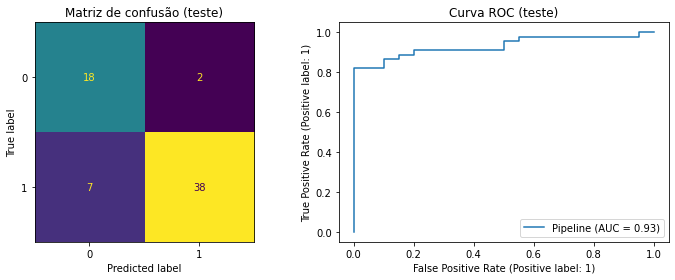

In [14]:
# --- 1) Seleção de X, y e split --------------------------------------------
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, RocCurveDisplay, ConfusionMatrixDisplay
)
import matplotlib.pyplot as plt

# alvo e features
TARGET = "Sex"
FEATS  = [c for c in df_encoded.columns if c != TARGET]

X = df_encoded[FEATS].to_numpy(dtype=float)
y = df_encoded[TARGET].to_numpy(dtype=int)

X_tr, X_te, y_tr, y_te = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

# --- 2) Pipeline (padronização + Regressão Logística) -----------------------
logreg = Pipeline(steps=[
    ("std", StandardScaler(with_mean=True, with_std=True)),
    ("clf", LogisticRegression(
        solver="liblinear",      # bom p/ datasets pequenos
        penalty="l2",
        C=1.0,
        max_iter=500,
        random_state=42
    ))
])

%time logreg.fit(X_tr, y_tr)

# --- 3) Métricas -------------------------------------------------------------
p_tr = logreg.predict(X_tr)
p_te = logreg.predict(X_te)
proba_te = logreg.predict_proba(X_te)[:, 1]

def show_classif_report(split, y_true, y_pred, proba=None):
    print(f"\n[{split}]")
    print("Acc :", accuracy_score(y_true, y_pred))
    print("Prec:", precision_score(y_true, y_pred, zero_division=0))
    print("Rec :", recall_score(y_true, y_pred))
    print("F1  :", f1_score(y_true, y_pred))
    if proba is not None:
        print("ROC-AUC:", roc_auc_score(y_true, proba))

show_classif_report("TREINO", y_tr, p_tr)
show_classif_report("TESTE ", y_te, p_te, proba_te)

# --- 4) Gráficos rápidos: matriz de confusão + ROC --------------------------
fig, ax = plt.subplots(1, 2, figsize=(10,4))

ConfusionMatrixDisplay(confusion_matrix(y_te, p_te)).plot(ax=ax[0], colorbar=False)
ax[0].set_title("Matriz de confusão (teste)")

from sklearn.metrics import plot_roc_curve
plot_roc_curve(logreg, X_te, y_te, ax=ax[1])  # usa o estimador
ax[1].set_title("Curva ROC (teste)")

plt.tight_layout()
plt.show()